<a href="https://colab.research.google.com/github/eruru0411/git-test/blob/master/Kaggle_bike.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* datetime - hourly date + timestamp
* season
 -  1 = spring, 2 = summer, 3 = fall, 4 = winter
* holiday - whether the day is considered a holiday
* workingday - whether the day is neither a weekend nor holiday
* weather 
  - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
  - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
  - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
  - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
* temp - temperature in Celsius
* atemp - "feels like" temperature in Celsius
* humidity - relative humidity
* windspeed - wind speed
* casual - number of non-registered user rentals initiated
* registered - number of registered user rentals initiated
* count - number of total rentals

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, roc_curve, classification_report, precision_recall_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Binarizer, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold

import warnings
warnings.filterwarnings(action="ignore")

plt.style.use('ggplot')
plt.rcParams['axes.unicode_minus'] = False

### 1. EDA

In [3]:
#1. EDA
#데이터 불러오기
df = pd.read_csv("bike_train.csv")
print(df.info()) #null값X, datetime->object #count:target data
print(df.shape) #(10886, 12)

pd.set_option('display.max_columns',None) #모든 열 출력
pd.set_option('display.max_rows', None) #모든 행 출력
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB
None
(10886, 12)
              datetime  season  holiday  workingday  weather  temp   atemp  \
0  2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1  2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2

In [4]:
#datetime : object->datetime으로 변경
df["datetime"] = pd.to_datetime(df["datetime"])
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB
None


In [5]:
#null값 확인 -> 전부 0
print(df.isnull().sum())

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64


In [6]:
#datetime(시계열 데이터)-> 년/월/일/시/분/초/요일로 나누기 + datetime 삭제
df["year"] = df["datetime"].dt.year
df["month"] = df["datetime"].dt.month
df["day"] = df["datetime"].dt.day
df["hour"] = df["datetime"].dt.hour
df["minute"] = df["datetime"].dt.minute
df["second"] = df["datetime"].dt.second
df["dayofweek"] = df["datetime"].dt.dayofweek
df = df.drop(["datetime"],axis=1)

[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Hour'),
 Text(0.5, 1.0, 'Average Count By Hour')]

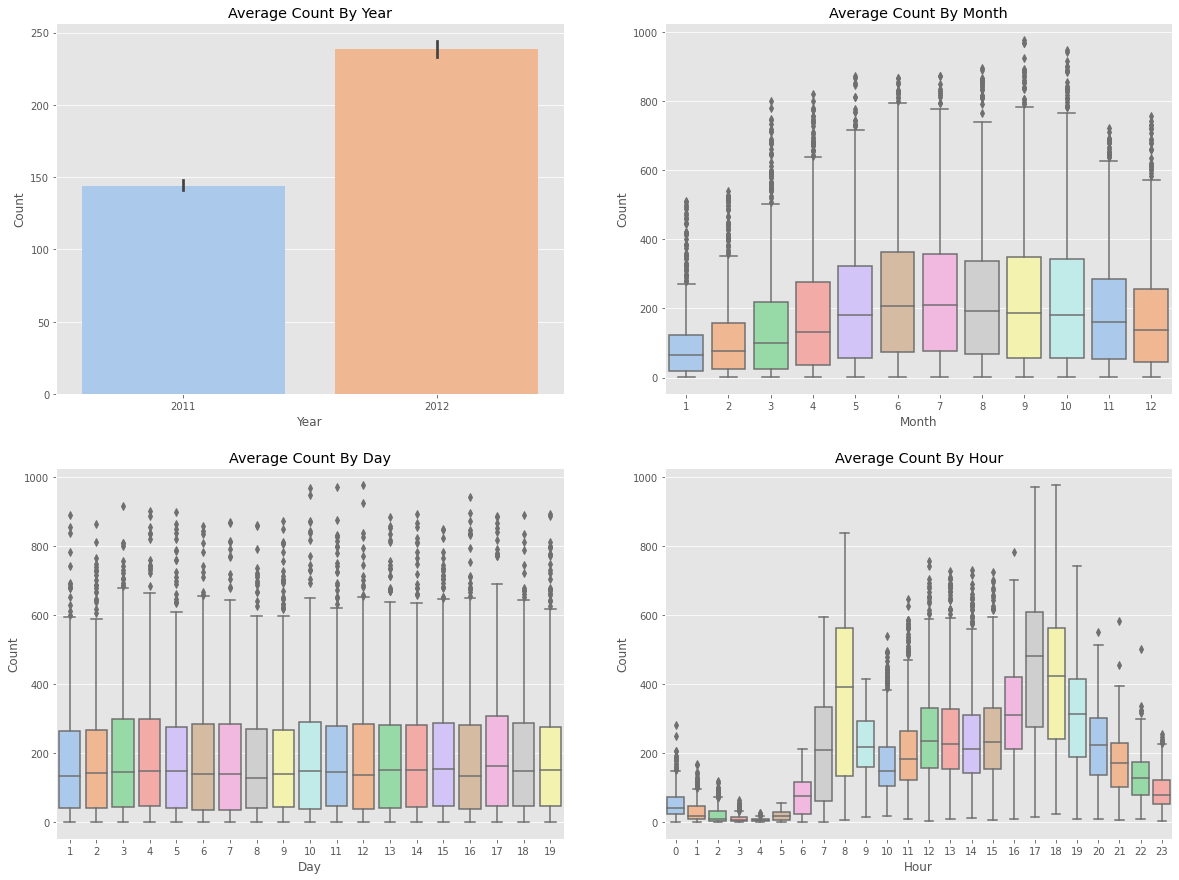

In [8]:
flg, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
flg.set_size_inches(20,15)

sns.barplot(data=df, x="year", y="count",ax=ax1, palette='pastel')
sns.boxplot(data=df, x="month", y="count",ax=ax2, palette='pastel')
sns.boxplot(data=df, x="day", y="count",ax=ax3, palette='pastel')
sns.boxplot(data=df, x="hour", y="count",ax=ax4, palette='pastel')

ax1.set(xlabel='Year', ylabel='Count',title="Average Count By Year")
ax2.set(xlabel='Month', ylabel='Count',title="Average Count By Month")
ax3.set(xlabel='Day', ylabel='Count',title="Average Count By Day")
ax4.set(xlabel='Hour', ylabel='Count', title="Average Count By Hour")

- 연도별 자전거 대여수를 비교한 결과, 2011년보다 2012년도에 자전거 대여수가 증가하였다.
- 월별 대여량은 6월에 가장 많고, 1월이 가장 적다.
- 시간별로는 8시와 17시-18시에 대여가 증가하는 것을 확인 할 수 있었다. 이는 출퇴근시간대에 자전거 이용이 활발히 이루어짐을 알 수 있다.
- 일별대여량은 1일~19일까지만 존재함. 피쳐로 사용하면 안 된다.
- 전체적으로 대여수에 이상치가 많이 발견되어, 모델 분석에 앞어 이상치 제거가 필요해보인다.

[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Working Day'),
 Text(0.5, 1.0, 'Count by Workingday')]

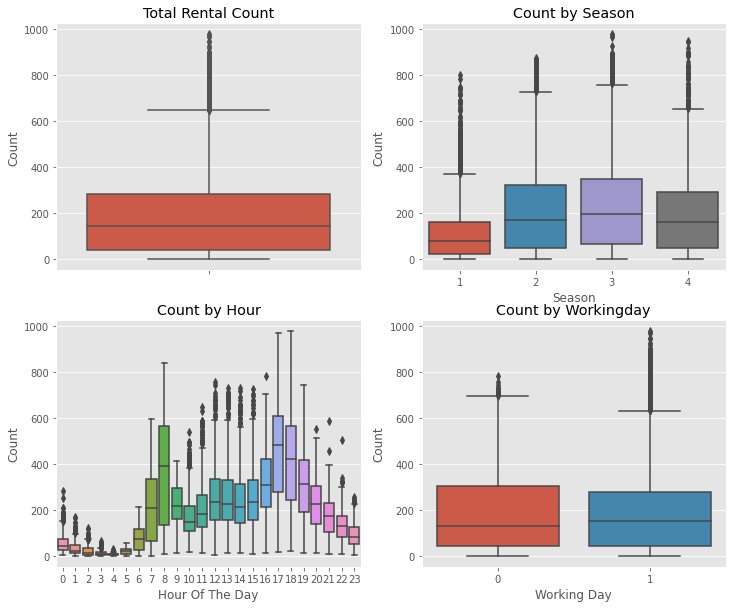

In [17]:
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(12, 10)
sns.boxplot(data=df,y="count",orient="v",ax=axes[0][0])
sns.boxplot(data=df,y="count",x="season",orient="v",ax=axes[0][1])
sns.boxplot(data=df,y="count",x="hour",orient="v",ax=axes[1][0])
sns.boxplot(data=df,y="count",x="workingday",orient="v",ax=axes[1][1])

axes[0][0].set(ylabel='Count',title="Total Rental Count")
axes[0][1].set(xlabel='Season', ylabel='Count',title="Count by Season")
axes[1][0].set(xlabel='Hour Of The Day', ylabel='Count',title="Count by Hour")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="Count by Workingday")

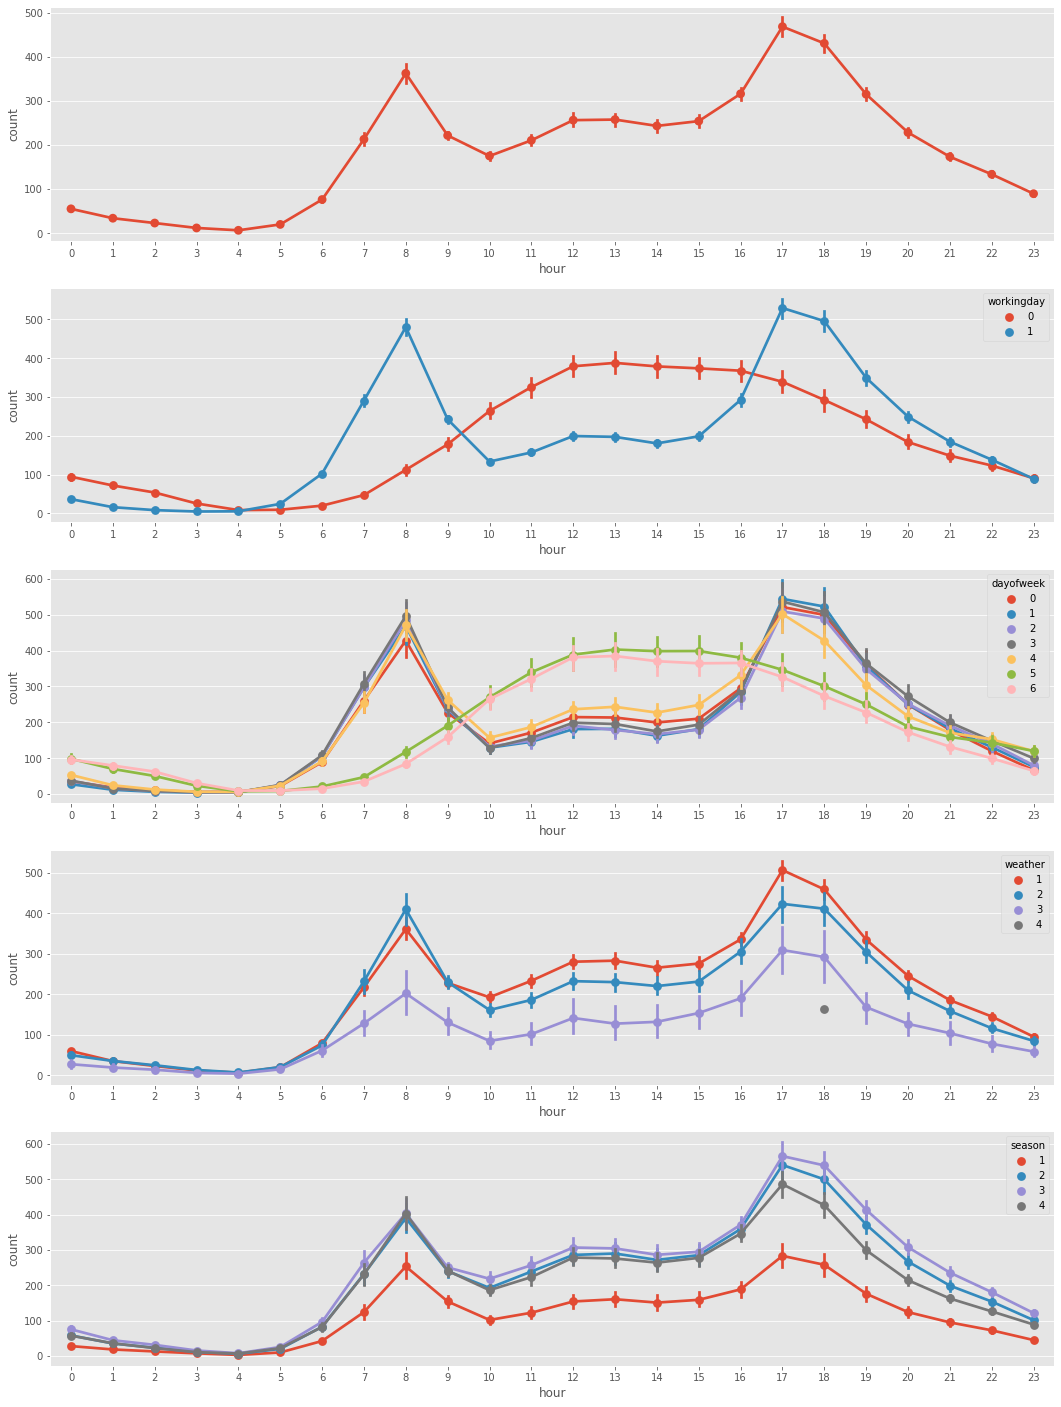

In [10]:
fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(nrows=5)
fig.set_size_inches(18,25)

sns.pointplot(data=df, x="hour", y="count", ax=ax1)
sns.pointplot(data=df, x="hour", y="count", hue="workingday", ax=ax2)
sns.pointplot(data=df, x="hour", y="count", hue="dayofweek", ax=ax3)
sns.pointplot(data=df, x="hour", y="count", hue="weather", ax=ax4)
sns.pointplot(data=df, x="hour", y="count", hue="season", ax=ax5)

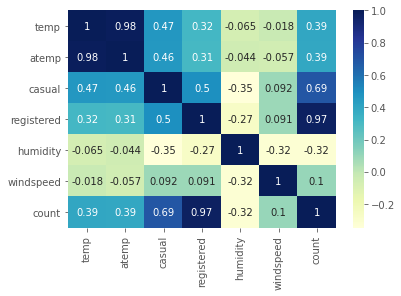

In [12]:
#상관관계 분석

sns.heatmap(df[["temp", "atemp", "casual", "registered", "humidity", "windspeed", "count"]].corr(), annot=True, fmt='.2g', cmap='YlGnBu')

- 온도, 습도, 풍속은 거의 연관관계가 없다
-
- atemp와 temp는 0.98로 상관관계가 높지만 피처로 사용하기에 적합한가?

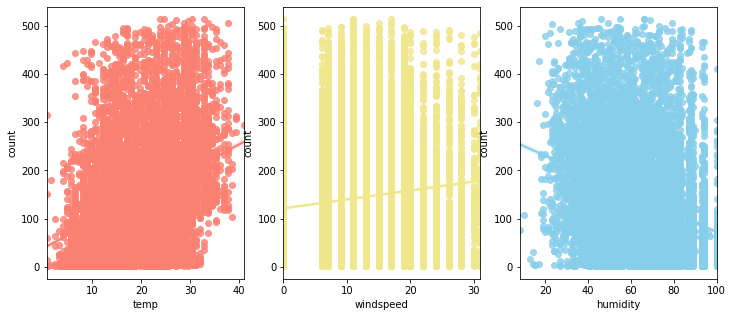

In [89]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
fig.set_size_inches(12,5)
sns.regplot(x="temp", y="count", data=df, ax=ax1, color='salmon')
sns.regplot(x="windspeed", y="count", data=df, ax=ax2, color='khaki')
sns.regplot(x="humidity", y="count", data=df, ax=ax3, color='skyblue')

In [18]:
# print(df.describe()) #day는 max가 19이므로 1~19일까지 밖에 데이터가 없으므로 삭제. minute, second는 0이므로 삭제

# #day, minute, second 삭제
# df = df.drop(["day", "minute", "second"],axis=1)
# print(df.columns)

In [87]:
#이상치
def CHECK_OUTLIER(df=None, column=None):
    Q1 = np.percentile(df[column].values, 25)
    Q3 = np.percentile(df[column].values, 75)
    IQR = Q3 - Q1
    IQR_weight = IQR * 1.5
    minimum = Q1 - IQR_weight
    maximum = Q3 + IQR_weight
    outlier_idx = df[column][  (df[column]<minimum) | (df[column]>maximum)  ].index
    return outlier_idx
    outlier_idx = CHECK_OUTLIER(df=df, column=col)
    print(col, oulier_idx)

numeric_columns = df.dtypes[df.dtypes != 'object'].index
for i, col in enumerate(numeric_columns) :
    outlier_idx = CHECK_OUTLIER(df=df, column=col)
    print(col , outlier_idx)
    df.drop(outlier_idx, axis=0, inplace=True)

season Int64Index([], dtype='int64')
holiday Int64Index([  372,   373,   374,   375,   376,   377,   378,   379,   380,
              381,
            ...
            10252, 10253, 10254, 10255, 10256, 10257, 10258, 10259, 10260,
            10261],
           dtype='int64', length=311)
workingday Int64Index([], dtype='int64')
weather Int64Index([5631], dtype='int64')
temp Int64Index([], dtype='int64')
atemp Int64Index([], dtype='int64')
humidity Int64Index([1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1099, 1100, 1101,
            1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1112],
           dtype='int64')
windspeed Int64Index([  175,   178,   194,   196,   265,   271,   471,   472,   473,
              474,
            ...
             9484,  9652,  9655,  9754,  9755, 10013, 10154, 10263, 10540,
            10853],
           dtype='int64', length=220)
casual Int64Index([ 1173,  1174,  1175,  1311,  1312,  1314,  1315,  1316,  1382,
             1383,
            

### Feature Engineering